In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from data_analysis import run_tsne, plot_tsne

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import shap

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
data_source = 'C:/Users/BiSBII/Documents/MM_ML/data/'

In [5]:
dataset_file = os.path.join(data_source, 'fluxomics_fc.csv')
metadata_file = os.path.join(data_source, 'GSE98923_metadata.xlsx')

In [6]:
metadata = pd.read_excel(metadata_file, index_col=0, sheet_name='NO_REPLICATES')

In [7]:
y_state = metadata['state']
y_cv = metadata['cultivar']

In [8]:
data = pd.read_csv(dataset_file, index_col=0)
data.shape

(8632, 73)

In [9]:
data = data.transpose()
data.shape

(73, 8632)

In [10]:
data = data.fillna(0)
data.shape

(73, 8632)

In [11]:
y_state.sort_index(key=lambda column: column.map(lambda e: list(data.index).index(e)), inplace=True)

# UNSUPERVISED ANALYSIS

apply variance threshold and scaling to all dataset

In [30]:
vt = VarianceThreshold(0)
data_filtered = vt.fit_transform(data)
cols_inds = vt.get_support(indices=True)
df_data_filtered = pd.DataFrame(data_filtered, index=data.index, columns=data.columns[cols_inds])
df_data_filtered.shape

(73, 2322)

In [35]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_data_filtered)
df_data_scaled = pd.DataFrame(data_scaled, columns=df_data_filtered.columns,
                              index=df_data_filtered.index)
df_data_scaled.shape

(73, 2322)

run tsne and plot the results

In [36]:
df_tsne = run_tsne(n_components=2, data=df_data_scaled)

In [37]:
df_tsne['factor'] = y_state

C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

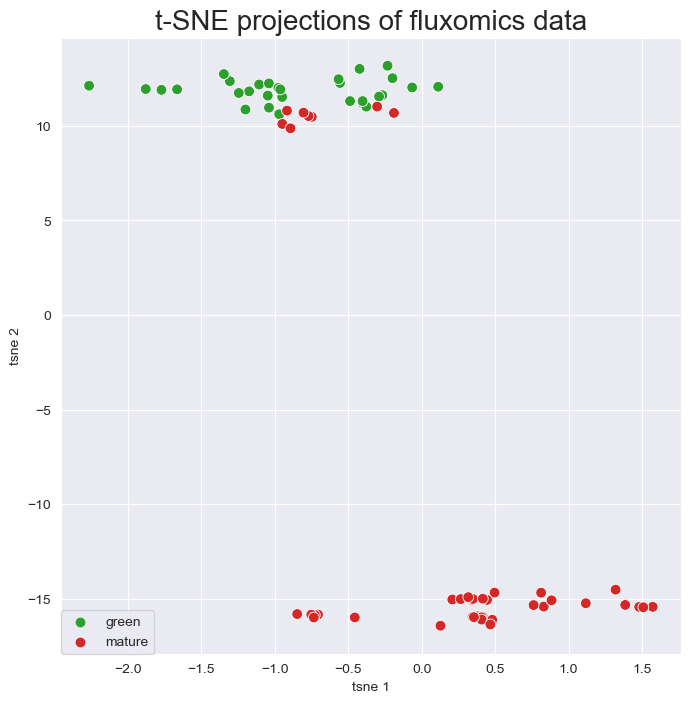

In [38]:
plot_tsne(data=df_tsne, name_fig='tsne_fluxes_state_fc', title='t-SNE projections of fluxomics data')

plot cluster mapping

In [ ]:
lut = {'green': 'g', 'mature': 'r'}
row_colors = y_state.map(lut)
sns.clustermap(df_data_scaled, row_colors=row_colors, figsize=(20, 15))

plot cluster mapping with correlations

In [ ]:
lut = {'green': 'g', 'mature': 'r'}
row_colors = y_state.map(lut)
sns.clustermap(df_data_scaled, metric='correlation', row_colors=row_colors, figsize=(20, 15))

# SUPERVISED ANALYSIS

# CROSS VALIDATION

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, LeaveOneOut, RepeatedStratifiedKFold

In [13]:
binary = {'green': 0, 'mature': 1}
binary_output = y_state.map(binary)
binary_output

MEAN SAMPLES
CS_time0_2012     0
CS_time0_2013     0
CS_time0_2014     0
CS_time10_2012    1
CS_time10_2013    1
                 ..
PN_time8_2013     1
PN_time8_2014     1
PN_time9_2012     1
PN_time9_2013     1
PN_time9_2014     1
Name: state, Length: 73, dtype: int64

In [14]:
scaler = StandardScaler()
vt = VarianceThreshold(0.001)
skb = SelectKBest(f_classif, k=500)
scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1, n_repeats=10)

CV -> LR

In [15]:
lr_cv = LogisticRegression()

pipe_lr = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', lr_cv)])

scores_lr = cross_validate(pipe_lr, data, binary_output, cv=cv, scoring=scoring)

print('test_accuracy', round(scores_lr['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_lr['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_lr['test_precision'].mean(), 2))
print('test_recall', round(scores_lr['test_recall'].mean(), 2))
print('test_f1', round(scores_lr['test_f1'].mean(), 2))

test_accuracy 0.96
test_balanced_accuracy 0.96
test_precision 0.97
test_recall 0.96
test_f1 0.96


Feature importance LR

In [45]:
dfs_lr = []

for idx,estimator in enumerate(scores_lr['estimator']):
    
    feature_importances_lr = pd.DataFrame(estimator.steps[3][1].coef_.transpose(),
                                          index = data.columns[estimator.steps[1][1].get_support(indices=True)],
                                          columns=['importance']).sort_values('importance', ascending=False)

    dfs_lr.append(feature_importances_lr)

complete_df_importance_lr = pd.concat(dfs_lr, axis=1)
complete_df_importance_lr.to_csv(os.path.join(data_source, 'LR_features_cv.csv'))
complete_df_importance_lr = complete_df_importance_lr.fillna(0)
complete_df_importance_lr['mean'] = abs(complete_df_importance_lr).mean(axis=1)

complete_df_importance_lr = abs(complete_df_importance_lr).sort_values(by=['mean'], ascending=False)
complete_df_importance_lr['mean']

RXN-6883__mito                      0.273896
RXNQT-4366__cyto                    0.272563
RXN-11530__er                       0.232260
RXN-11388__er                       0.178202
THREONINE--TRNA-LIGASE-RXN__chlo    0.178202
                                      ...   
TR1000084__vacu__cyto               0.000364
RXN-5985__mito                      0.000364
RXN-17741__er                       0.000344
TI0000239__vacu__cyto               0.000344
METHYLVALERATE-RXN__chlo            0.000316
Name: mean, Length: 1081, dtype: float64

<Axes: >

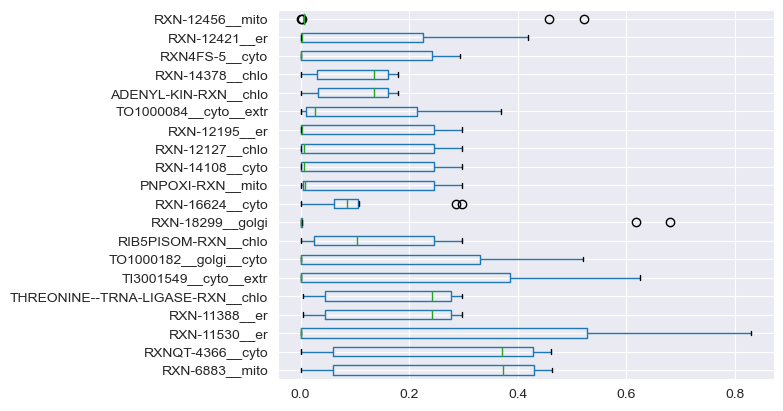

In [46]:
complete_df_importance_lr.iloc[:20, :-1].transpose().boxplot(vert=False)

CV -> RF

In [47]:
subdata_lr = data[complete_df_importance_lr.iloc[:10, -1].index]
group_df_lr = subdata_lr.groupby(y_state).mean()
maxvals_lr = group_df_lr.idxmax()
colours = {'green': 'g', 'mature': 'r'}
colours_map_lr = maxvals_lr.map(colours)
colours_map_lr

(73, 10)

<BarContainer object of 10 artists>

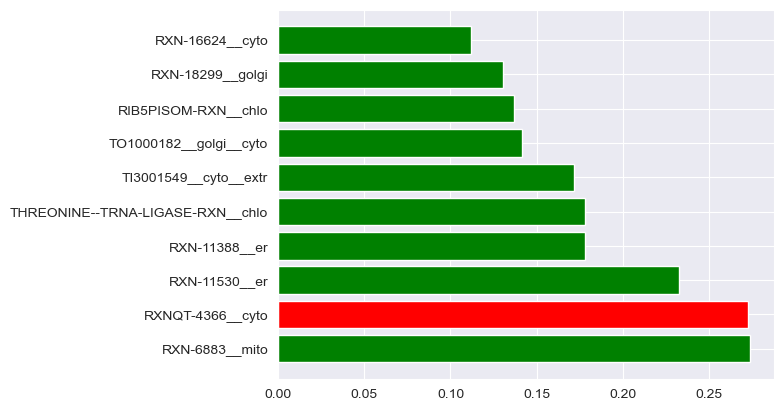

In [52]:
plt.barh(complete_df_importance_lr.iloc[:10, -1].index, complete_df_importance_lr.iloc[:10, -1], color=colours_map_lr)

In [16]:
rf_cv = RandomForestClassifier(random_state=1)

pipe_rf = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', rf_cv)])

scores_rf = cross_validate(pipe_rf, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_rf['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_rf['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_rf['test_precision'].mean(), 2))
print('test_recall', round(scores_rf['test_recall'].mean(), 2))
print('test_f1', round(scores_rf['test_f1'].mean(), 2))

test_accuracy 0.97
test_balanced_accuracy 0.97
test_precision 0.98
test_recall 0.97
test_f1 0.97


RF feature importance

In [22]:
dfs_rf = []

for idx,estimator in enumerate(scores_rf['estimator']):
    
    feature_importances_rf = pd.DataFrame(estimator.steps[3][1].feature_importances_,
                                          index = data.columns[estimator.steps[1][1].get_support(indices=True)],
                                          columns=['importance']).sort_values('importance', ascending=False)
    
    dfs_rf.append(feature_importances_rf)
 
    # feature_importances_rf.to_csv(os.path.join(data_source, 'RF_features_cv' + str(idx) + '.csv'))

complete_df_importance_rf = pd.concat(dfs_rf, axis=1)
# complete_df_importance_rf.to_csv(os.path.join(data_source, 'RF_features_cv.csv'))
complete_df_importance_rf = complete_df_importance_rf.fillna(0)
complete_df_importance_rf['mean'] = complete_df_importance_rf.mean(axis=1)

complete_df_importance_rf = complete_df_importance_rf.sort_values(by=['mean'], ascending=False)
complete_df_importance_rf['mean']

RXN-11388__er                                  0.035602
RXNQT-4366__cyto                               0.021796
THREONINE--TRNA-LIGASE-RXN__chlo               0.020127
RXN-2947__cyto                                 0.017520
TI3000278__cyto__extr                          0.016370
                                                 ...   
HYDROXYBENZALDEHYDE-OXIDATION-NAD-RXN__cyto    0.000000
RXN-9944__chlo                                 0.000000
1.1.1.34-RXN__cyto                             0.000000
RXN0-7280__cyto                                0.000000
RXN-12669__pero                                0.000000
Name: mean, Length: 1081, dtype: float64

<Axes: >

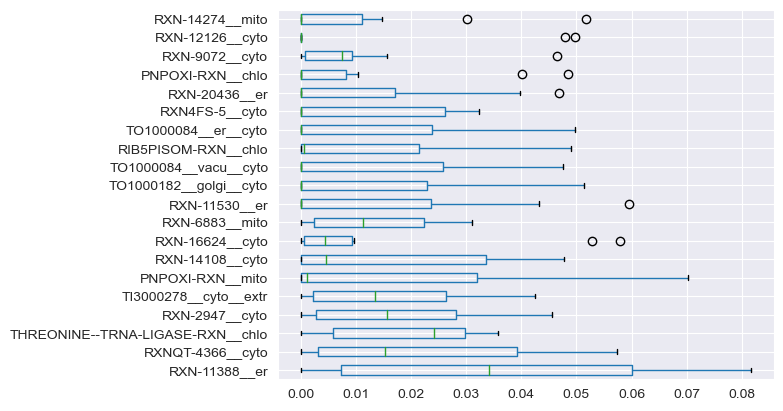

In [38]:
complete_df_importance_rf.iloc[:20, :-1].transpose().boxplot(vert=False)

In [39]:
subdata = data[complete_df_importance_rf.iloc[:20, -1].index]
group_df = subdata.groupby(y_state).mean()
maxvals = group_df.idxmax()
colours_map = maxvals.map(colours)
colours_map

(73, 20)

<BarContainer object of 10 artists>

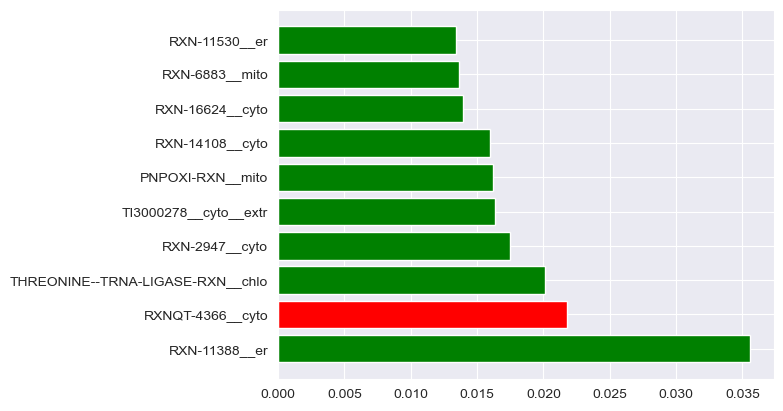

In [43]:
plt.barh(complete_df_importance_rf.iloc[:10, -1].index, complete_df_importance_rf.iloc[:10, -1], color=colours_map)

CV - KNN

In [17]:
knn_cv = KNeighborsClassifier()

pipe_knn = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', knn_cv)])

scores_knn = cross_validate(pipe_knn, data, binary_output, cv=cv, scoring=scoring)
for key in scores_knn:
    print(key, round(scores_knn[key].mean(), 2))

fit_time 0.6
score_time 0.32
test_accuracy 0.96
test_balanced_accuracy 0.95
test_precision 0.96
test_recall 0.98
test_f1 0.97


CV - DT

In [18]:
tree_cv = tree.DecisionTreeClassifier(random_state=1)

pipe_tree = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', tree_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_tree = cross_validate(pipe_tree, data, binary_output, cv=cv, scoring=scoring)
for key in scores_tree:
    print(key, round(scores_tree[key].mean(), 2))

fit_time 0.61
score_time 0.3
test_accuracy 0.96
test_balanced_accuracy 0.96
test_precision 0.98
test_recall 0.95
test_f1 0.96


CV - SVM

In [19]:
svm_cv = svm.SVC()

pipe_svm = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', svm_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_svm = cross_validate(pipe_svm, data, binary_output, cv=cv, scoring=scoring)
for key in scores_svm:
    print(key, round(scores_svm[key].mean(), 2))

fit_time 0.61
score_time 0.3
test_accuracy 0.93
test_balanced_accuracy 0.93
test_precision 0.96
test_recall 0.94
test_f1 0.94


CV - SVM LINEAR

In [26]:
svm_l_cv = svm.SVC(kernel='linear')

pipe_svm_l = Pipeline([('transformer1', vt), ('transformer2', skb), ('transformer3', scaler), ('estimator', svm_l_cv)])

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

scores_svm_l = cross_validate(pipe_svm_l, data, binary_output, cv=cv, scoring=scoring, return_estimator=True)

print('test_accuracy', round(scores_svm_l['test_accuracy'].mean(), 2))
print('test_balanced_accuracy', round(scores_svm_l['test_balanced_accuracy'].mean(), 2))
print('test_precision', round(scores_svm_l['test_precision'].mean(), 2))
print('test_recall', round(scores_svm_l['test_recall'].mean(), 2))
print('test_f1', round(scores_svm_l['test_f1'].mean(), 2))

test_accuracy 0.96
test_balanced_accuracy 0.95
test_precision 0.96
test_recall 0.98
test_f1 0.97


In [54]:
dfs_svm = []

for idx,estimator in enumerate(scores_svm_l['estimator']):
    
    feature_importances_svm = pd.DataFrame(estimator.steps[3][1].coef_.transpose(),
                                          index = data.columns[estimator.steps[1][1].get_support(indices=True)],
                                          columns=['importance']).sort_values('importance', ascending=False)

    dfs_svm.append(feature_importances_svm)

complete_df_importance_svm = pd.concat(dfs_svm, axis=1)
complete_df_importance_svm.to_csv(os.path.join(data_source, 'SVM_features_cv.csv'))
complete_df_importance_svm = complete_df_importance_svm.fillna(0)
complete_df_importance_svm['mean'] = abs(complete_df_importance_svm).mean(axis=1)

complete_df_importance_svm = complete_df_importance_svm.sort_values(by=['mean'], ascending=False)
complete_df_importance_svm['mean']

RXN-6883__mito                         1.585542e-01
RXNQT-4366__cyto                       1.577845e-01
TI3001549__cyto__extr                  1.449062e-01
RXN-11530__er                          1.445693e-01
RXN-18299__golgi                       1.055737e-01
                                           ...     
TO1000119__vacu__cyto                  1.080053e-11
TRYPTOPHAN--TRNA-LIGASE-RXN__cyto      5.819353e-13
DTDPDEHYDRHAMEPIM-RXN__cyto            5.819353e-13
RXN-14448__pero                        5.819353e-13
ACETOACETYL-COA-HYDROLASE-RXN__mito    8.755976e-18
Name: mean, Length: 1081, dtype: float64

<Axes: >

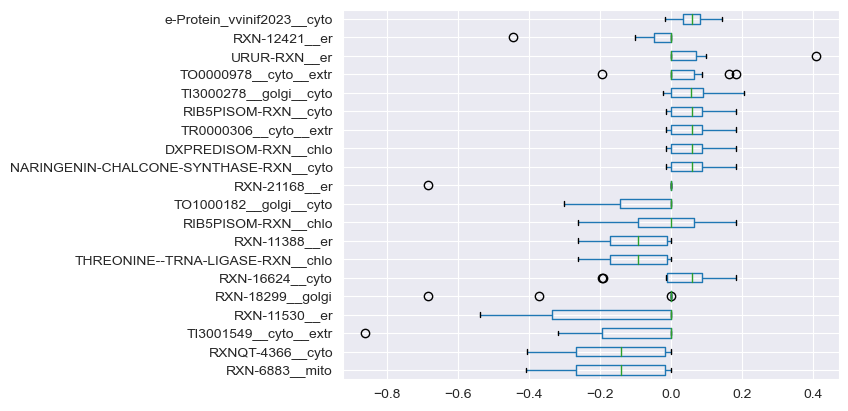

In [288]:
complete_df_importance_svm.iloc[:20, :-1].transpose().boxplot(vert=False)

In [56]:
subdata_svm = data[complete_df_importance_svm.iloc[:20, -1].index]
group_df_svm = subdata_svm.groupby(y_state).mean()
maxvals_svm = group_df_svm.idxmax()
colours_map_svm = maxvals.map(colours)

(73, 20)

<BarContainer object of 10 artists>

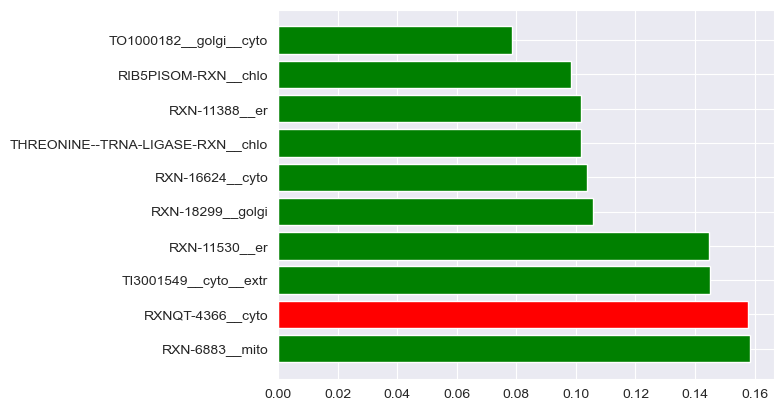

In [60]:
plt.barh(complete_df_importance_svm.iloc[:10, -1].index, complete_df_importance_svm.iloc[:10, -1], color=colours_map_svm)

# LOO

In [155]:
loo = LeaveOneOut()

scoring = ['accuracy', 'balanced_accuracy']

scores = cross_validate(pipe_rf, data, binary_output, cv=loo, scoring=scoring)
for key in scores:
    print(key, round(scores[key].mean(), 2))

C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\BiSBII\anaconda3\envs\multiomics\Lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


fit_time 0.17
score_time 0.04
test_accuracy 0.97
test_balanced_accuracy 0.97


# Manual analysis to calculate SHAP values (only for KNN e RF - bests results)

## KNN

In [15]:
CV_repeats = 10
cv_repeated = RepeatedStratifiedKFold(n_splits=10, random_state=1, n_repeats=10)
scores_knn = {'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

scaler = StandardScaler()
vt = VarianceThreshold(0.001)
skb = SelectKBest(f_classif, k=500)

In [16]:
shap_values_per_cv_knn = dict()
for sample in data.index:
    shap_values_per_cv_knn[sample] = {} 
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv_knn[sample][CV_repeat] = {}

In [17]:
rep = 0    
for i, (train_index, test_index) in enumerate(cv_repeated.split(data, binary_output)):

    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]

    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]

    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    kb2_fit = skb.fit(X_train_filtered, y_train)

    train_filtered2 = kb2_fit.transform(X_train_filtered)
    test_filtered2 = kb2_fit.transform(X_test_filtered)

    cols_inds = kb2_fit.get_support(indices=True)

    X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)

    X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)

    features_selected = X_train_filtered.columns[cols_inds]

    scaler_model = StandardScaler().fit(X_train_filtered2)
    X_train_scaled = scaler_model.transform(X_train_filtered2)
    X_test_scaled = scaler_model.transform(X_test_filtered2)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)

    knn = KNeighborsClassifier()

    knn.fit(X_train_final, y_train)

    knn_y_pred = knn.predict(X_test_final.values)

    scores_knn['accuracy'].append(accuracy_score(y_test, knn_y_pred))
    scores_knn['balanced_accuracy'].append(balanced_accuracy_score(y_test, knn_y_pred))
    scores_knn['precision'].append(precision_score(y_test, knn_y_pred))
    scores_knn['recall'].append(recall_score(y_test, knn_y_pred))
    scores_knn['f1'].append(f1_score(y_test, knn_y_pred))

    explainer = shap.Explainer(knn.predict, X_test_final, max_evals=1100, seed=42)
    shap_values = explainer(X_test_final.values)
    
    df = pd.DataFrame(shap_values.values, columns=features_selected, index=[data.index[i] for i in test_index])
    for ind in df.index:
        shap_values_per_cv_knn[ind][rep] = df.loc[[ind]]
    
    splits = [9, 19, 29, 39, 49, 59, 69, 79, 89]
    if i in splits:
        rep += 1
    
print('accuracy', round(np.array(scores_knn['accuracy']).mean(), 2))
print('balanced_accuracy', round(np.array(scores_knn['balanced_accuracy']).mean(), 2))
print('precision', round(np.array(scores_knn['precision']).mean(), 2))
print('recall', round(np.array(scores_knn['recall']).mean(), 2))
print('f1', round(np.array(scores_knn['f1']).mean(), 2))

accuracy 0.96
balanced_accuracy 0.95
precision 0.96
recall 0.98
f1 0.97


In [22]:
average_shap_values_knn = []

for sample in shap_values_per_cv_knn:
    sample_dfs = [shap_values_per_cv_knn[sample][rep] for rep in shap_values_per_cv_knn[sample]]
    concat_df = pd.concat(sample_dfs, axis=0)
    concat_df = concat_df.fillna(0)
    mean_df = concat_df.mean(axis=0)
    mean_df.name = sample
    average_shap_values_knn.append(mean_df)

In [23]:
concat_mean_knn = pd.concat(average_shap_values_knn, axis=1).transpose()
concat_mean_knn = concat_mean_knn.fillna(0)
concat_mean_knn.shape

(73, 575)

In [81]:
final_shap_array_knn = np.array(concat_mean_knn)

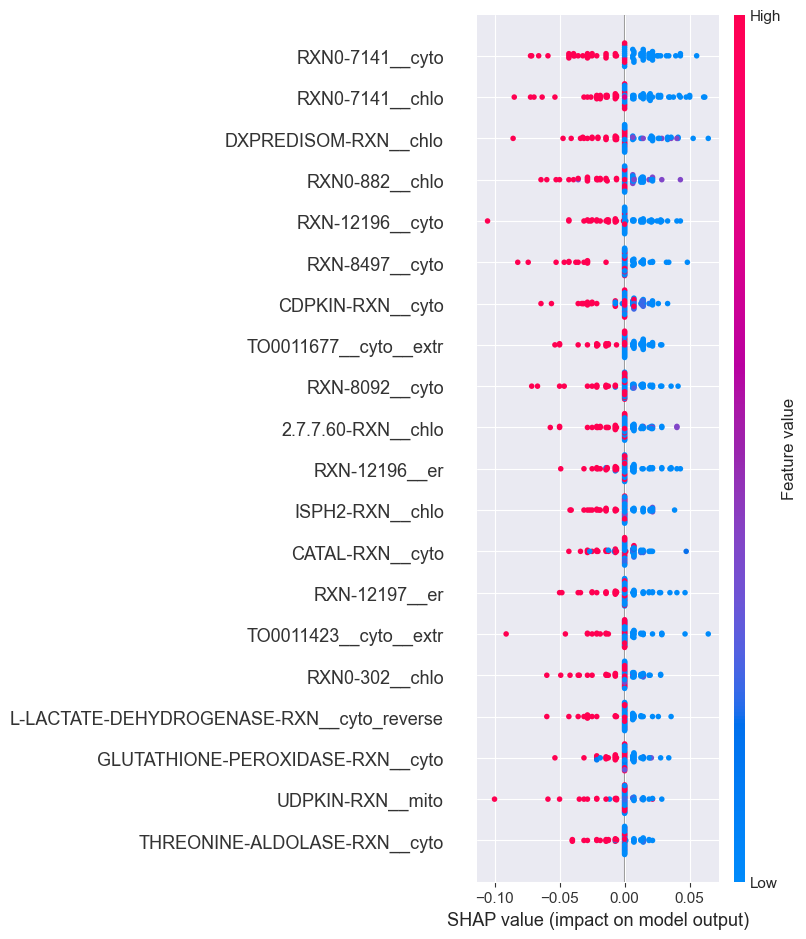

In [82]:
shap.summary_plot(final_shap_array_knn, data[concat_mean_knn.columns])

## RANDOM FORESTS

In [59]:
scores_rf = {'accuracy': [], 'balanced_accuracy': [], 'precision': [], 'recall': [], 'f1': []}

In [60]:
shap_values_per_cv = dict()
for sample in data.index:
    shap_values_per_cv[sample] = {} 
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}

In [72]:
rep = 0    
for i, (train_index, test_index) in enumerate(cv_repeated.split(data, binary_output)):
    
    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]

    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]

    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    kb2_fit = skb.fit(X_train_filtered, y_train)

    train_filtered2 = kb2_fit.transform(X_train_filtered)
    test_filtered2 = kb2_fit.transform(X_test_filtered)

    cols_inds = kb2_fit.get_support(indices=True)

    X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)

    X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)

    features_selected = X_train_filtered.columns[cols_inds]

    scaler_model = StandardScaler().fit(X_train_filtered2)
    X_train_scaled = scaler_model.transform(X_train_filtered2)
    X_test_scaled = scaler_model.transform(X_test_filtered2)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)

    rf = RandomForestClassifier(random_state=1)

    rf.fit(X_train_final, y_train)

    rf_y_pred = rf.predict(X_test_final)

    scores_rf['accuracy'].append(accuracy_score(y_test, rf_y_pred))
    scores_rf['balanced_accuracy'].append(balanced_accuracy_score(y_test, rf_y_pred))
    scores_rf['precision'].append(precision_score(y_test, rf_y_pred))
    scores_rf['recall'].append(recall_score(y_test, rf_y_pred))
    scores_rf['f1'].append(f1_score(y_test, rf_y_pred))

    explainer = shap.Explainer(rf.predict, X_test_final, max_evals=1100, seed=42)
    shap_values = explainer(X_test_final)
    
    df = pd.DataFrame(shap_values.values, columns=features_selected, index=[data.index[i] for i in test_index])
    for ind in df.index:
        shap_values_per_cv[ind][rep] = df.loc[[ind]]
    
    splits = [9, 19, 29, 39, 49, 59, 69, 79, 89]
    if i in splits:
        rep += 1
    
print('accuracy', round(np.array(scores_rf['accuracy']).mean(), 2))
print('balanced_accuracy', round(np.array(scores_rf['balanced_accuracy']).mean(), 2))
print('precision', round(np.array(scores_rf['precision']).mean(), 2))
print('recall', round(np.array(scores_rf['recall']).mean(), 2))
print('f1', round(np.array(scores_rf['f1']).mean(), 2))

accuracy 0.97
balanced_accuracy 0.97
precision 0.98
recall 0.97
f1 0.97


In [73]:
average_shap_values = []

for sample in shap_values_per_cv:
    sample_dfs = [shap_values_per_cv[sample][rep] for rep in shap_values_per_cv[sample]]
    concat_df = pd.concat(sample_dfs, axis=0)
    concat_df = concat_df.fillna(0)
    mean_df = concat_df.mean(axis=0)
    mean_df.name = sample
    average_shap_values.append(mean_df)

In [74]:
concat_mean = pd.concat(average_shap_values, axis=1).transpose()
concat_mean = concat_mean.fillna(0)
concat_mean.shape

(73, 575)

In [75]:
final_shap_array = np.array(concat_mean)

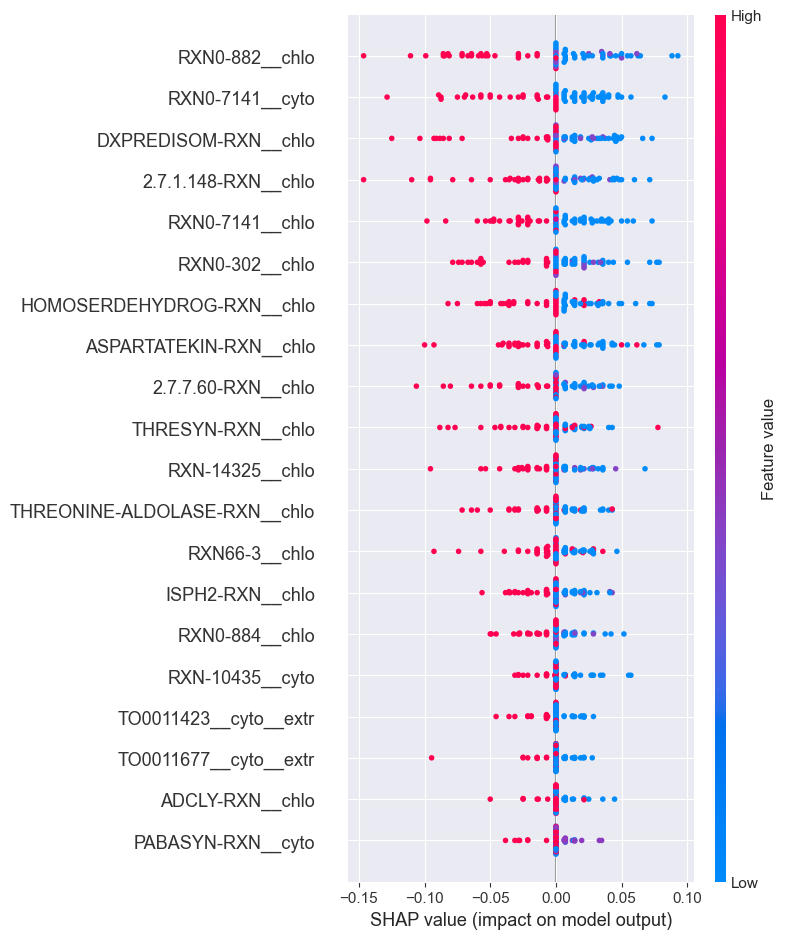

In [76]:
shap.summary_plot(final_shap_array, data[concat_mean.columns])

# ANALYSE SHAP VALUES FOR THE AROUND VERAISON SAMPLES

In [15]:
shap_values_per_cv = dict()
for sample in data.index:
    shap_values_per_cv[sample] = {} 
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}

In [16]:
base_values_per_cv = dict()
for sample in data.index:
    base_values_per_cv[sample] = {} 
    for CV_repeat in range(CV_repeats):
        base_values_per_cv[sample][CV_repeat] = {}

In [19]:
rep = 0    
for i, (train_index, test_index) in enumerate(cv_repeated.split(data, binary_output)):

    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]

    y_train = binary_output.iloc[train_index]
    y_test = binary_output.iloc[test_index]

    filter_train = vt.fit(train)

    train_filtered = filter_train.transform(train)
    test_filtered = filter_train.transform(test)

    cols_inds = vt.get_support(indices=True)

    X_train_filtered = pd.DataFrame(train_filtered, index=train.index, columns=train.columns[cols_inds])

    X_test_filtered = pd.DataFrame(test_filtered, index=test.index, columns=test.columns[cols_inds])

    kb2_fit = skb.fit(X_train_filtered, y_train)

    train_filtered2 = kb2_fit.transform(X_train_filtered)
    test_filtered2 = kb2_fit.transform(X_test_filtered)

    cols_inds = kb2_fit.get_support(indices=True)

    X_train_filtered2 = pd.DataFrame(train_filtered2, columns=X_train_filtered.columns[cols_inds], index=X_train_filtered.index)

    X_test_filtered2 = pd.DataFrame(test_filtered2, columns=X_test_filtered.columns[cols_inds], index=X_test_filtered.index)

    features_selected = X_train_filtered.columns[cols_inds]

    scaler_model = StandardScaler().fit(X_train_filtered2)
    X_train_scaled = scaler_model.transform(X_train_filtered2)
    X_test_scaled = scaler_model.transform(X_test_filtered2)
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train_filtered2.columns, index=X_train_filtered2.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test_filtered2.columns, index=X_test_filtered2.index)

    rf = RandomForestClassifier(random_state=1)

    rf.fit(X_train_final, y_train)

    rf_y_pred = rf.predict(X_test_final)

    explainer = shap.Explainer(rf.predict, X_test_final, max_evals=1100, seed=42)
    shap_values = explainer(X_test_final)
    
    df = pd.DataFrame(shap_values.values, columns=features_selected, index=[data.index[i] for i in test_index])
    x = 0
    for ind in df.index:
        shap_values_per_cv[ind][rep] = df.loc[[ind]]
        base_values_per_cv[ind][rep] = shap_values.base_values[x]
        x += 1
    
    splits = [9, 19, 29, 39, 49, 59, 69, 79, 89]
    if i in splits:
        rep += 1

In [21]:
average_shap_values = []

for sample in shap_values_per_cv:
    sample_dfs = [shap_values_per_cv[sample][rep] for rep in shap_values_per_cv[sample]]
    concat_df = pd.concat(sample_dfs, axis=0)
    concat_df = concat_df.fillna(0)
    mean_df = concat_df.mean(axis=0)
    mean_df.name = sample
    average_shap_values.append(mean_df)

In [22]:
concat_mean = pd.concat(average_shap_values, axis=1).transpose()
concat_mean = concat_mean.fillna(0)
concat_mean.shape

(73, 575)

In [23]:
final_shap_array = np.array(concat_mean)

In [25]:
df_base = pd.DataFrame.from_dict(base_values_per_cv)
df_base_mean = df_base.mean(axis=0)
base_array = np.array(df_base_mean)

In [26]:
obj = shap.Explanation(values=final_shap_array, data=np.array(data[concat_mean.columns]), base_values=base_array,feature_names=concat_mean.columns)

In [28]:
veraison = [list(concat_mean.index).index(x) for x in concat_mean.index if 'time3' in x]
veraison

[19, 20, 21, 52, 53, 54]

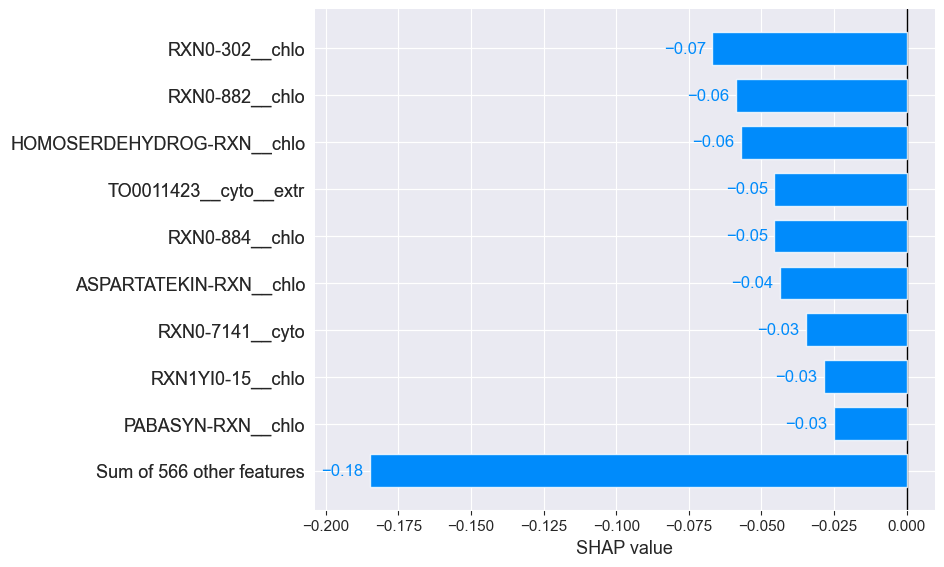

In [35]:
shap.plots.bar(obj[54])

In [40]:
CS_veraison = concat_mean.iloc[[19, 20, 21], :]

In [41]:
CS_veraison_array = np.array(CS_veraison)

In [48]:
cs_ver = shap.Explanation(values=CS_veraison_array, data=np.array(data.loc[CS_veraison.index, CS_veraison.columns]), base_values=base_array[19:22], feature_names=CS_veraison.columns)

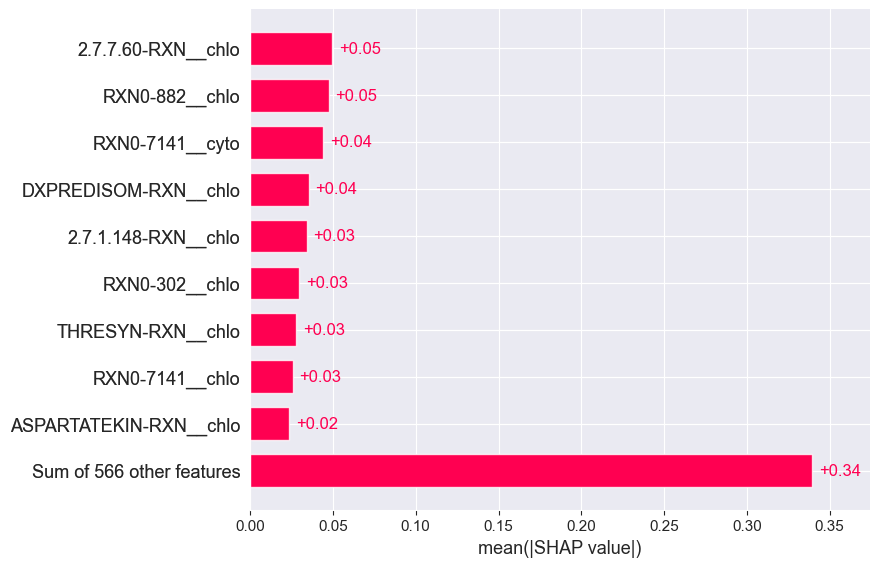

In [49]:
shap.plots.bar(cs_ver)

In [ ]:
PN_veraison = concat_mean.iloc[[52, 53, 54], :]

In [45]:
PN_veraison_array = np.array(PN_veraison)

array([[ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [-0.00625,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ]])

In [58]:
pn_ver = shap.Explanation(values=PN_veraison_array, data=np.array(data.loc[PN_veraison.index, PN_veraison.columns]), base_values=base_array[52:55], feature_names=PN_veraison.columns)

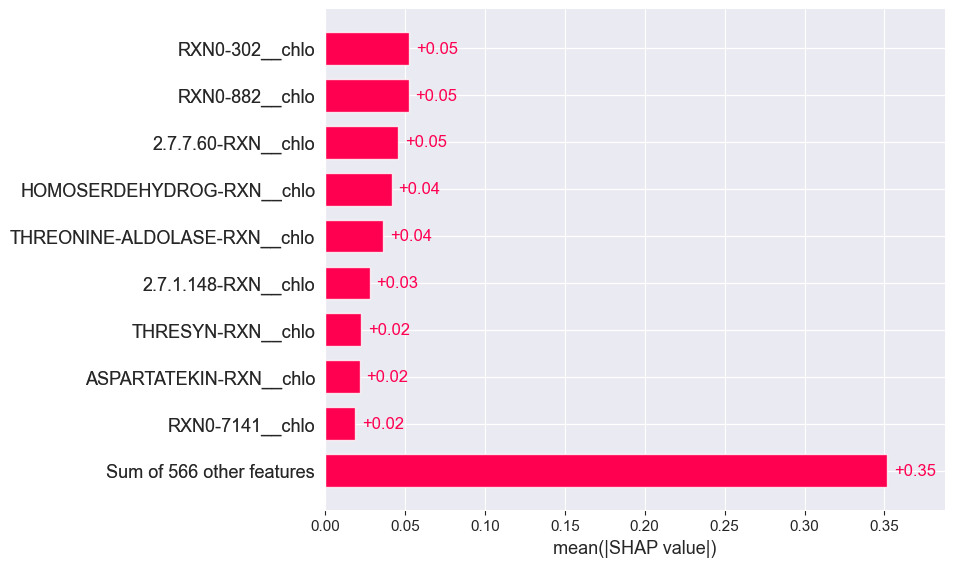

In [59]:
shap.plots.bar(pn_ver)

In [56]:
veraison = concat_mean.iloc[[19, 20, 21, 52, 53, 54], :]

In [57]:
veraison_array = np.array(veraison)

In [62]:
ver = shap.Explanation(values=veraison_array, data=np.array(data.loc[veraison.index, veraison.columns]), base_values=base_array[[19, 20, 21, 52, 53, 54]], feature_names=veraison.columns)

In [71]:
cv = ['Cabernet Sauvignon' if 'CS' in i else "Pinot Noir" for i in veraison.index]
cv

['Cabernet Sauvignon',
 'Cabernet Sauvignon',
 'Cabernet Sauvignon',
 'Pinot Noir',
 'Pinot Noir',
 'Pinot Noir']

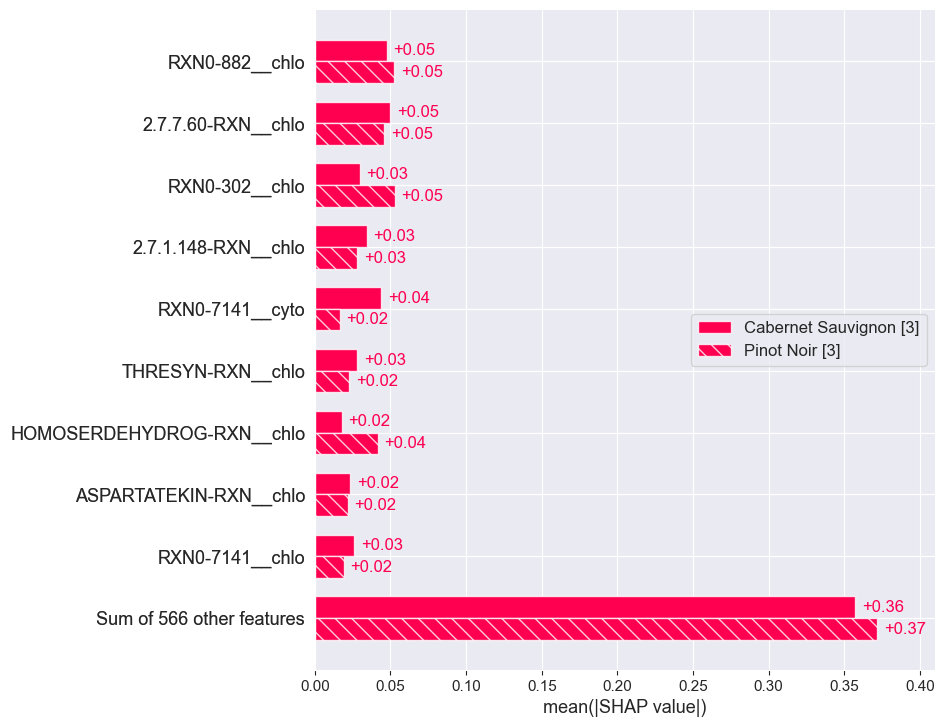

In [72]:
shap.plots.bar(ver.cohorts(cv))